In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/project_ae')

In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.3 MB/s eta 0:00:00


In [3]:
!pip install torchinfo

# Convolutional Auto-encoder - Camus Dataset


This notebook shows how to train, test and evaluate a Convolutional Auto-encoder to generate an output label exactly as input, so the segmented shape. The dataset is available on [CAMUS dataset](https://humanheart-project.creatis.insa-lyon.fr/database/#collection/6373703d73e9f0047faa1bc8).


# I. Install dependencies <a class="anchor" id="install"></a>


In [ ]:
%%capture project_path_setup

import sys

if "../" in sys.path:
    print(sys.path)
else:
    sys.path.append("../")
    print(sys.path)

In [ ]:
%%capture packages_install

# Make sure the repo's package and its dependencies are installed
%pip install -e ../.

# II. Dataset <a class="anchor" id="dataset"></a>

Once the environment is successfully setup, download the CAMUS dataset by executing the following cell. The dataset will be downloaded to the `data/` folder.

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm

# Make sure the data is downloaded and extracted where it should be
if not Path("../data/camus_64").is_dir():
    import zipfile
    from io import BytesIO
    from urllib.request import urlopen

    zipurl = "https://www.creatis.insa-lyon.fr/~bernard/camus/camus_64.zip"
    with urlopen(zipurl) as zipresp:
        with zipfile.ZipFile(BytesIO(zipresp.read())) as zfile:
            for member in tqdm(
                zfile.infolist(), desc="Downloading and extracting data", position=0, leave=True
            ):
                try:
                    zfile.extract(member, "../data/")
                except zipfile.error as e:
                    pass

Data splitting into training, validation and testing sets (80% of the data for training, 10% for validation and 10% for testing). The split is done by patient ID, so that the same patient will not appear in different sets.

In [ ]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from src.utils.file_and_folder_operations import subdirs

# Specify the data directory
data_dir = Path("../data/camus_64").resolve()

# List all the patients id
keys = subdirs(data_dir, prefix="patient", join=False)

# Split the patients into 80/10/10 train/val/test sets
train_keys, val_and_test_keys = train_test_split(keys, train_size=0.8, random_state=12345)
val_keys, test_keys = train_test_split(val_and_test_keys, test_size=0.5, random_state=12345)

train_keys = sorted(train_keys)
val_keys = sorted(val_keys)
test_keys = sorted(test_keys)

# Create train, val and test datalist
viws_instants = ["2CH_ED", "2CH_ES", "4CH_ED", "4CH_ES"]
train_datalist = [
    {
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in train_keys
    for view in viws_instants
]

val_datalist = [
    {
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in val_keys
    for view in viws_instants
]

test_datalist = [
    {
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in test_keys
    for view in viws_instants
]

Once the data is split, we will create a `Dataset` object for each set. This object will be used to load the data during training and testing.

In [ ]:
import numpy as np
from monai.data import CacheDataset
from monai.transforms import Compose, EnsureChannelFirstd, LoadImaged

# Transforms to load data
load_transforms = [
    LoadImaged(keys=["label"], image_only=True),  # Load label
    EnsureChannelFirstd(keys=["label"]),  # Make sure the first dimension is the channel dimension
]

# Define transforms for training, validation and testing
train_transforms = Compose(load_transforms)
val_transforms = Compose(load_transforms)
test_transforms = Compose(load_transforms)

# Use CacheDataset to accelerate training and validation
train_ds = CacheDataset(data=train_datalist, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms, cache_rate=1.0)
test_ds = CacheDataset(data=test_datalist, transform=test_transforms, cache_rate=1.0)

Loading dataset: 100%|██████████| 200/200 [00:00<00:00, 555.43it/s]


train_idx:  943
val_idx:  196
test_idx:  150


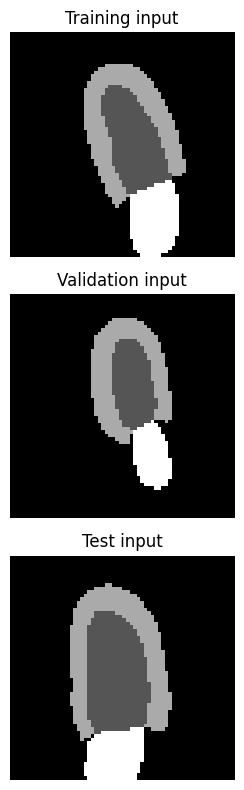

In [ ]:
from matplotlib import pyplot as plt
from src.utils.visualizations import imagesc

# Get a random index to display the example annotation from each dataset
train_idx = np.random.randint(len(train_ds))
val_idx = np.random.randint(len(val_ds))
test_idx = np.random.randint(len(test_ds))

# Print the selected indices
print("train_idx: ", train_idx)
print("val_idx: ", val_idx)
print("test_idx: ", test_idx)

# Visualize a random example from each dataset

figure = plt.figure(figsize=(8, 8))
train_sample = train_ds[train_idx]
label = train_sample["label"].detach().cpu().numpy()[0].transpose(1, 0)
ax = figure.add_subplot(3, 1, 1)
imagesc(ax, label, title="Training input", show_colorbar=False)

val_sample = val_ds[val_idx]
label = val_sample["label"].detach().cpu().numpy()[0].transpose(1, 0)
ax = figure.add_subplot(3, 1, 2)
imagesc(ax, label, title="Validation input", show_colorbar=False)

test_sample = test_ds[test_idx]
label = test_sample["label"].detach().cpu().numpy()[0].transpose(1, 0)
ax = figure.add_subplot(3, 1, 3)
imagesc(ax, label, title="Test input", show_colorbar=False)
figure.tight_layout()
plt.show()

In [ ]:
np.unique(label)

array([0., 1., 2., 3.], dtype=float32)

# III. Train <a class="anchor" id="train"></a>


### Definition of Convolutional Auto-encoder architecture

In [4]:
import torch
import torch.nn as nn
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
            #nn.Dropout2d(p=0.2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to modify the number of channels
        if bilinear:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                DoubleConv(in_channels, out_channels),
                #nn.Dropout2d(p=0.2)
            )
        else:
            self.up = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                #nn.Dropout2d(p=0.2)
            )

    def forward(self, x):
        return self.up(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class AE_Conv(nn.Module):
    def __init__(self, in_channels, out_channels, init_channel, bilinear=True):
        super(AE_Conv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.init_channel = init_channel
        self.bilinear = bilinear

        self.inc = DoubleConv(in_channels, init_channel)
        self.down1 = Down(init_channel, init_channel*2)
        self.down2 = Down(init_channel*2, init_channel*4)
        self.down3 = Down(init_channel*4, init_channel*8)
        #self.down4 = Down(init_channel*8, init_channel*16)
        #self.up1 = Up(init_channel*16, init_channel*8, bilinear)
        self.up2 = Up(init_channel*8, init_channel*4, bilinear)
        self.up3 = Up(init_channel*4, init_channel*2, bilinear)
        self.up4 = Up(init_channel*2, init_channel, bilinear)
        self.outc = OutConv(init_channel, out_channels)
        self.relu = nn.ReLU()

        self._initialize_weights()

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        #x = self.down4(x)
        #x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.outc(x)
        #x = self.relu(x)
        return x

    def _initialize_weights(self):
       for m in self.modules():
           if isinstance(m, nn.Conv2d):
               nn.init.kaiming_normal_(m.weight)
               if m.bias is not None:
                   nn.init.zeros_(m.bias)
           elif isinstance(m, nn.BatchNorm2d):
               nn.init.constant_(m.weight, 1)
               nn.init.constant_(m.bias, 0)

Create a convolutional auto-encoder.

In [5]:
from torchinfo import summary
import torch
import torch.nn.functional as F

input_channel = 1  # This is the number of input channels in the image
input_shape = (input_channel, 64, 64)  # This is the shape of the input image to the network
output_channel = 1  # This is the number of output channel
output_shape = (output_channel, 64, 64)  # This is the shape of the output image
init_channels = 32  # This is the output channel's number of input convolution

ae_conv = AE_Conv(input_channel, output_channel, init_channels)

# Print the summary of the network
summary_kwargs = dict(col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=3, verbose=0)
summary(ae_conv, (1, *input_shape), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                        Input Shape               Output Shape              Kernel Shape              Param #
AE_Conv                                       [1, 1, 64, 64]            [1, 1, 64, 64]            --                        --
├─DoubleConv: 1-1                             [1, 1, 64, 64]            [1, 32, 64, 64]           --                        --
│    └─Sequential: 2-1                        [1, 1, 64, 64]            [1, 32, 64, 64]           --                        --
│    │    └─Conv2d: 3-1                       [1, 1, 64, 64]            [1, 32, 64, 64]           [3, 3]                    320
│    │    └─BatchNorm2d: 3-2                  [1, 32, 64, 64]           [1, 32, 64, 64]           --                        64
│    │    └─ReLU: 3-3                         [1, 32, 64, 64]           [1, 32, 64, 64]           --                        --
│    │    └─Conv2d: 3-4                       [1, 32, 64, 64]           [1, 32, 64, 64]           [3, 3] 

In [ ]:
import numpy as np
import torch

# Test the pixel value range of auto-encoder input and output
random_image = np.random.rand(64, 64)
tensor_image = torch.FloatTensor(random_image)
tensor_image = tensor_image.unsqueeze(0).unsqueeze(0)
with torch.no_grad():
    ae_output = ae_conv(tensor_image)

print("Random Image:")
print(random_image)

print("\nAE Output:")
print(ae_output.squeeze().numpy())

Random Image:
[[0.0691737  0.97841038 0.72151585 ... 0.65977269 0.23775282 0.332936  ]
 [0.07296194 0.5503809  0.18181346 ... 0.99252762 0.29792812 0.79651903]
 [0.51955569 0.27828745 0.11800161 ... 0.53299744 0.75044462 0.68012499]
 ...
 [0.45965325 0.45122782 0.85030106 ... 0.7207187  0.39860277 0.07862123]
 [0.41701563 0.76931613 0.33191613 ... 0.74739882 0.96180128 0.32320816]
 [0.76172717 0.35823596 0.55587264 ... 0.74447077 0.56396702 0.50323102]]

AE Output:
[[ 0.13286215 -0.07848419 -0.06373744 ...  0.11027015 -0.9027427
   1.3941506 ]
 [ 0.94547987  0.6757958   0.93376225 ... -0.00272804 -0.07608961
   1.5931842 ]
 [ 1.2902831   2.0126083   2.6581516  ... -0.48192132 -0.40263894
   1.0601056 ]
 ...
 [ 0.02673986  0.38357466  0.72156703 ...  1.8313422   0.57816917
   1.1568308 ]
 [ 0.48103487  0.66631657  1.1012052  ...  1.4808253   0.97328967
   1.7304142 ]
 [ 0.86939585  1.3170218   1.5045699  ...  0.6493453   0.48067293
   1.4845116 ]]


### Definition of optimizer and loss function
We will use the Adam optimizer. The loss function is the MSE loss.

In [ ]:
from functools import partial
import torch
from torch.nn import MSELoss

loss_function = MSELoss()

optimizer = torch.optim.Adam(ae_conv.parameters(),lr=0.005,betas=(0.9,0.999),eps=1e-04,weight_decay=0.0005,amsgrad=False)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.01 if epoch < 10 else (0.005 if 10 <= epoch < 100 else 0.001))

### Definition of training function

In [ ]:
import os
import time
from typing import Union

import torch.nn.functional as F
from monai.data import DataLoader
from torch import nn
from torch.utils.data import Dataset
from tqdm.auto import tqdm

from skimage.metrics import structural_similarity as ssim

def train_process(
    train_ds: Dataset,
    val_ds: Dataset,
    num_workers: int,
    model: nn.Module,
    loss_function: nn.Module,
    optimizer: torch.optim.Optimizer,
    sheduler: torch.optim.lr_scheduler._LRScheduler,
    batch_size: int = 2,
    max_epochs: int = 30,
    log_dir: Union[Path, str] = Path("/content/drive/MyDrive/project_ae/logs/ae"),
    val_interval=1,
) -> tuple[float, list[float], list[float], list[int], list[float]]:
    """Trains a neural network model for segmentation on the provided datasets using the specified parameters.

    Args:
        train_ds: Training dataset.
        val_ds: Validation dataset.
        num_workers: Number of workers to use for data loading.
        model: Neural network model.
        loss_function: Loss function.
        optimizer: Optimizer.
        num_classes: Number of classes to segment.
        batch_size: Number of batch size. Defaults to 2.
        max_epochs: Maximum training epochs. Defaults to 30.
        log_dir: Path to the logging directory. Defaults to Path("../logs/camus_segmentation").
        val_interval: Epoch interval to perform evaluation steps. Defaults to 1.

    Returns:
        - Total time taken for training.
        - List containing training loss values for each epoch.
        - List containing validation loss values for each evaluation epoch.
        - List containing epochs where validation is performed.
        - List containing metric values for each evaluation epoch.
    """
    # Create train and validation dataloaders
    train_dataloader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    val_dataloader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )

    # Determine the device to run the model on
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU detected, training on: {device}!\n")
    else:
        device = torch.device("cpu")
        print("GPU not detected, training on CPU!\n")

    # Move the model to the device
    model = model.to(device)

    # Convert log directory to Path object if needed
    if not isinstance(log_dir, Path):
        log_dir = Path(log_dir)
    # Create the log directory if it does not exist
    log_dir.mkdir(parents=True, exist_ok=True)

    # Define some variables to keep track of the best metric values, epoch time and losses
    best_metric = -1
    best_metric_epoch = -1
    epoch_train_loss_values = []
    epoch_val_loss_values = []
    metric_values = []
    epoch_val = []
    total_start = time.time()

    accuracy_list = []
    ssim_list = []

    fit_pbar = tqdm(range(max_epochs), desc="Training", unit="epoch", position=0, leave=True)
    pbar_metrics = {"train/loss": None, "val/loss": None, "val/accuracy": None, "val/ssim": None}

    for epoch in fit_pbar:
        model.train()
        epoch_loss = 0
        epoch_val_loss = 0
        epoch_ssim = 0
        epoch_acc = 0
        step = 0
        for batch_data in train_dataloader:
            step += 1
            inputs = batch_data["label"].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, inputs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar_metrics["loss"] = loss.item()
            pbar_metrics["train_batch"] = f"{step}/{len(train_dataloader)}"
            fit_pbar.set_postfix(pbar_metrics)

        epoch_loss /= step
        epoch_train_loss_values.append(epoch_loss)
        pbar_metrics["train/loss"] = epoch_loss
        pbar_metrics.pop("loss")
        pbar_metrics.pop("train_batch")
        fit_pbar.set_postfix(pbar_metrics)
        if (epoch + 1) % val_interval == 0:
            step = 0
            acc_per_epoch = 0
            ssim_per_epoch = 0
            model.eval()
            with torch.no_grad():
                for val_data in val_dataloader:
                    step += 1
                    val_inputs = val_data["label"].to(device)

                    val_outputs = model(val_inputs)
                    val_loss = loss_function(val_outputs, val_inputs)
                    epoch_val_loss += val_loss.item()
                    pbar_metrics["loss"] = val_loss.item()
                    pbar_metrics["val_batch"] = f"{step}/{len(val_dataloader)}"
                    fit_pbar.set_postfix(pbar_metrics)

                    if val_inputs.size() != val_outputs.size():
                      raise ValueError("Error!")

                    # accuracy calculation for 1 batch
                    round_val_outputs = torch.round(val_outputs)
                    correct_pixel = torch.sum(torch.eq(val_inputs, round_val_outputs)).item()
                    total_pixel = val_inputs.numel()
                    acc = (correct_pixel / total_pixel) * 100
                    acc_per_epoch += acc

                    # ssim calculation for 1 batch
                    ssim_per_sample = 0
                    out_np = val_outputs.cpu().detach().numpy()
                    in_np = val_inputs.cpu().detach().numpy()
                    for i in range(out_np.shape[0]):
                        ssim_per_sample += ssim(out_np[i, 0], in_np[i, 0])
                    ssim_per_epoch += ssim_per_sample / out_np.shape[0]


                epoch_val_loss /= step
                epoch_val_loss_values.append(epoch_val_loss)
                epoch_val.append(epoch + 1)
                pbar_metrics.pop("loss")
                pbar_metrics.pop("val_batch")
                pbar_metrics["val/loss"] = float(epoch_val_loss)

                epoch_acc = acc_per_epoch / step
                pbar_metrics["val/accuracy"] = epoch_acc
                fit_pbar.set_postfix(pbar_metrics)
                accuracy_list.append(epoch_acc)

                epoch_ssim = ssim_per_epoch / step
                pbar_metrics["val/ssim"] = epoch_ssim
                fit_pbar.set_postfix(pbar_metrics)
                ssim_list.append(epoch_ssim)

                #val_metric = acc_per_epoch
                val_metric = epoch_ssim
                metric_values.append(val_metric)


                if val_metric > best_metric:
                    best_metric = val_metric
                    best_metric_epoch = epoch + 1
                    # Save best metric model checkpoint
                    torch.save(
                        {
                            "max_epochs": max_epochs,
                            "current_epoch": epoch + 1,
                            "best_metric_epoch": best_metric_epoch,
                            "train_loss": epoch_train_loss_values,
                            "val_loss": epoch_val_loss_values,
                            "epoch_val": epoch_val,
                            "metric_values": metric_values,
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                        },
                        str(log_dir / "best_metric_model_checkpoint.pth"),
                    )

                    # Save the best whole model
                    torch.save(model, str(log_dir / "best_metric_model.pth"))

        scheduler.step()

        # Save last model checkpoint
        torch.save(
            {
                "max_epochs": max_epochs,
                "current_epoch": epoch + 1,
                "best_metric_epoch": best_metric_epoch,
                "train_loss": epoch_train_loss_values,
                "val_loss": epoch_val_loss_values,
                "epoch_val": epoch_val,
                "metric_values": metric_values,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            str(log_dir / "last_model_checkpoint.pth"),
        )

        # Save the whole model
        torch.save(model, str(log_dir / "last_model.pth"))

    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {(time.time() - total_start):.4f}"
    )
    return (
        time.time() - total_start,
        epoch_train_loss_values,
        epoch_val_loss_values,
        epoch_val,
        metric_values,
        accuracy_list,
        ssim_list
    )

### Definition of training hyperparameters
In this section, we will define the hyperparameters for training, such as the number of epochs, the learning rate, the batch size, etc.

In [ ]:
batch_size = 4  # Number of batch size
max_epochs = 200  # Number of epochs to train the model
num_workers = os.cpu_count() - 1  # Number of workers to use for data loading

# Train the model
(
    total_time,
    epoch_train_loss_values,
    epoch_val_loss_values,
    epoch_val,
    metric_values,
    accuracy_list,
    ssim_list
) = train_process(
    train_ds=train_ds,
    val_ds=val_ds,
    num_workers=num_workers,
    model=ae_conv,
    loss_function=loss_function,
    optimizer=optimizer,
    sheduler=scheduler,
    batch_size=batch_size,
    max_epochs=max_epochs,
    log_dir="/content/drive/MyDrive/project_ae/logs/ae",
)

GPU detected, training on: cuda!



Training:   0%|          | 0/200 [00:00<?, ?epoch/s]

train completed, best_metric: 0.9187 at epoch: 197 total time: 4152.8488


# IV. Visualize learning curves and predictions <a class="anchor" id="visualize"></a>

### Plot training losses, validation losses and validation SSIM over epochs

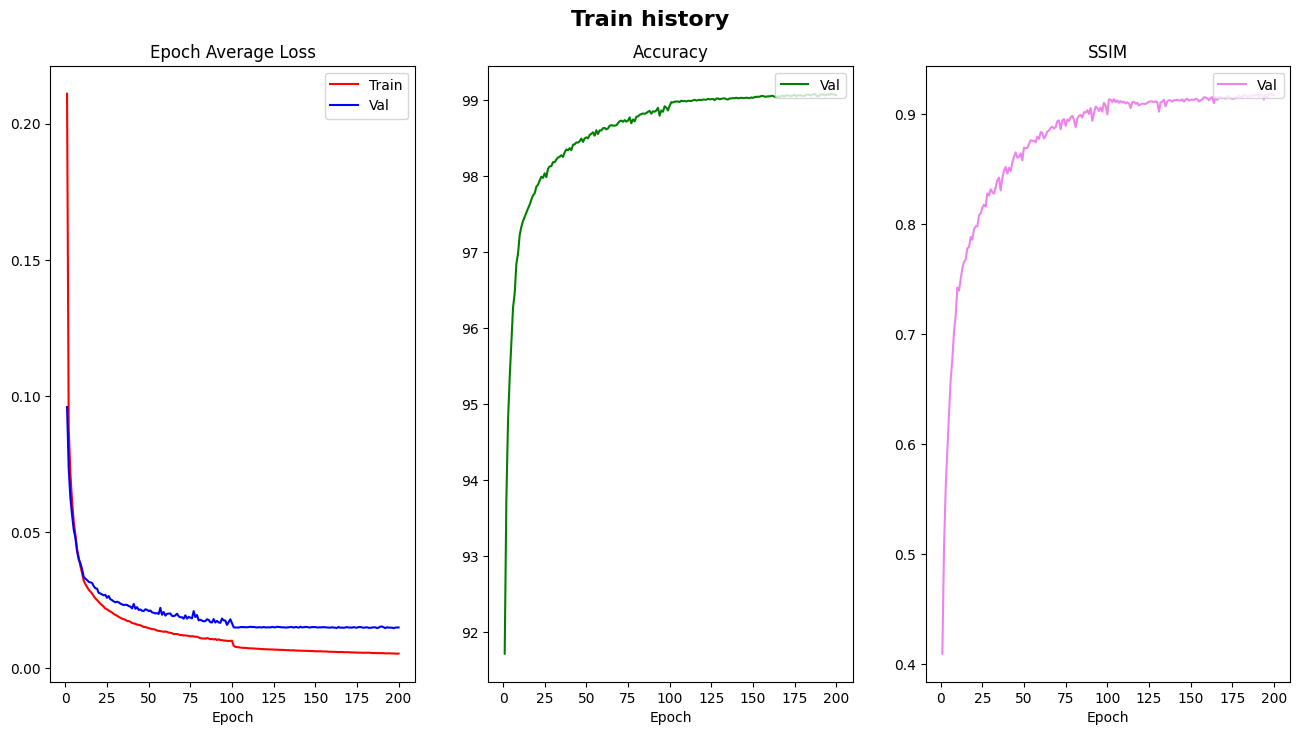

In [ ]:
from matplotlib.ticker import MaxNLocator

trains_epoch = list(range(1, max_epochs + 1, 1))
vals_epochs = epoch_val

plt.figure("train", (16, 8))
plt.suptitle("Train History", x=0.5, y=0.95, fontsize=16, fontweight='bold')
ax = plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(trains_epoch, epoch_train_loss_values, color="red", label="Train")
plt.plot(vals_epochs, epoch_val_loss_values, color="blue", label="Val")
plt.legend(loc="upper right")

ax = plt.subplot(1, 3, 2)
plt.title("Accuracy")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(vals_epochs, accuracy_list, color="green", label="Val")
plt.legend(loc="upper right")

ax = plt.subplot(1, 3, 3)
plt.title("SSIM")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(vals_epochs, ssim_list, color="violet", label="Val")
plt.legend(loc="upper right")

### Prediction on the test set
First, we create the dataloader from the test dataset we defined at the beginning.

In [ ]:
import os
# Create the test dataloader
num_workers = os.cpu_count() - 1

test_dataloader = DataLoader(
    test_ds,
    batch_size=1,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

# Create an iterator to iterate over the test dataloader
test_dataloader_iter = iter(test_dataloader)

Then, we perform the inference on a random sample from the test dataset and plot the prediction.

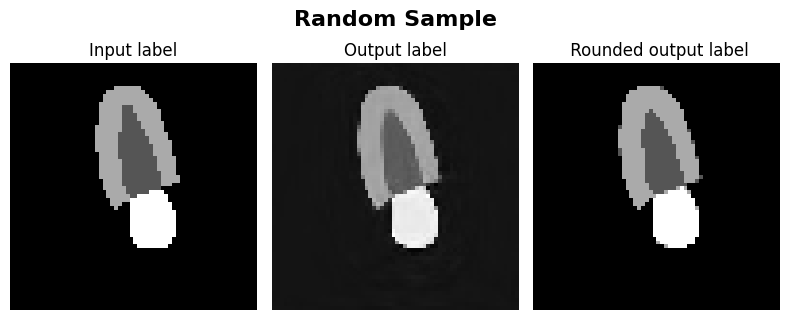

In [ ]:
import torch
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

batch_data = next(test_dataloader_iter)
#model = torch.load('/content/drive/MyDrive/project_ae/logs/ae/best_metric_model.pth', map_location=torch.device('cpu'))
model = torch.load('/content/drive/MyDrive/project_ae/logs/ae/best_metric_model.pth')

with torch.no_grad():
    model.eval()
    model.to(device)
    label = batch_data["label"].to(device)
    output = model(label)
    output_rounded = np.round(output)

    label = label.squeeze().detach().cpu().numpy().transpose(1, 0)
    output = output.squeeze().detach().cpu().numpy().transpose(1, 0)
    output_rounded = output_rounded.squeeze().transpose(1, 0)

# Plot the input label, output label, rounded output label
figure = plt.figure(figsize=(8, 8))
figure.suptitle("Random Sample", x=0.5, y=0.7, fontsize=16, fontweight='bold')
ax = figure.add_subplot(1, 3, 1)
imagesc(ax, label, title="Input label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 2)
imagesc(ax, output, title="Output label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 3)
imagesc(ax, output_rounded, title=" Rounded output label", show_colorbar=False)
figure.tight_layout()
plt.show()

Finally, we perform the inference on the whole test dataset and plot the result for the best and the worst prediction.

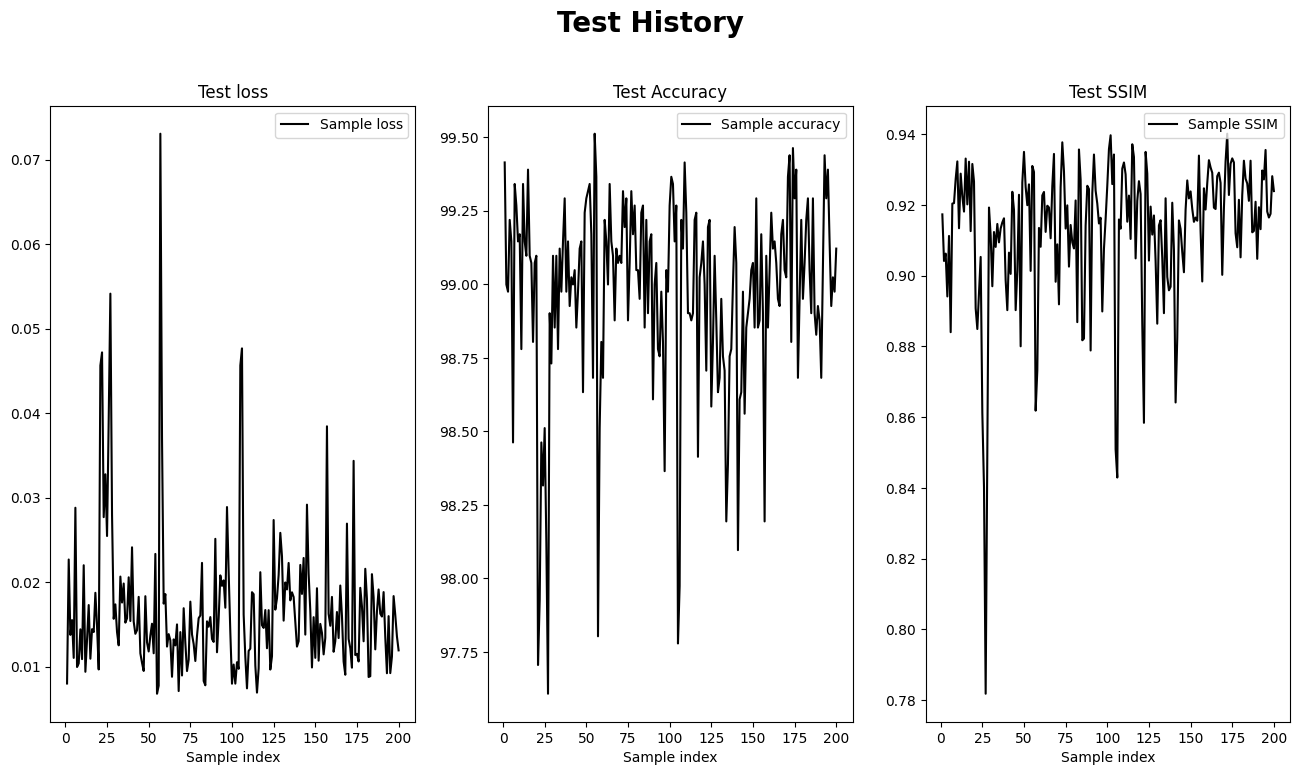

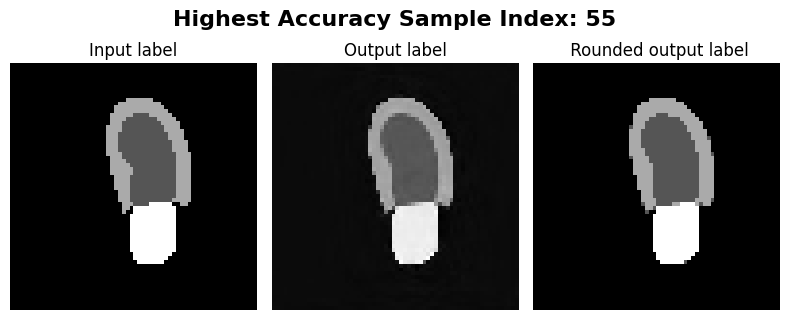

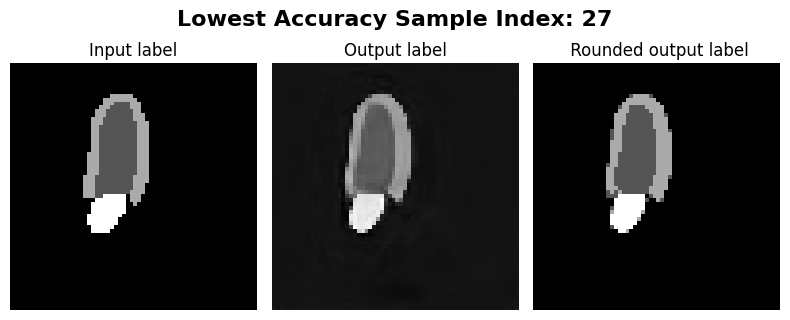

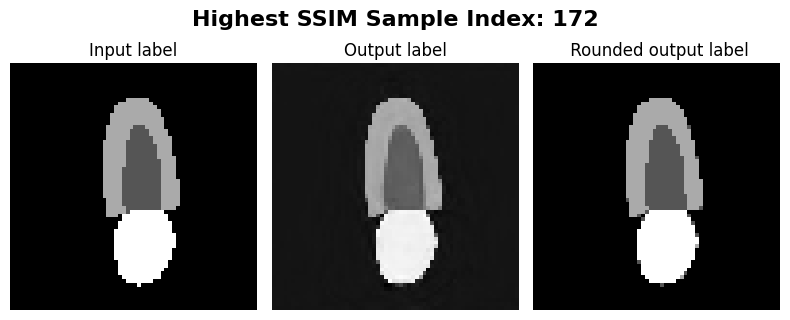

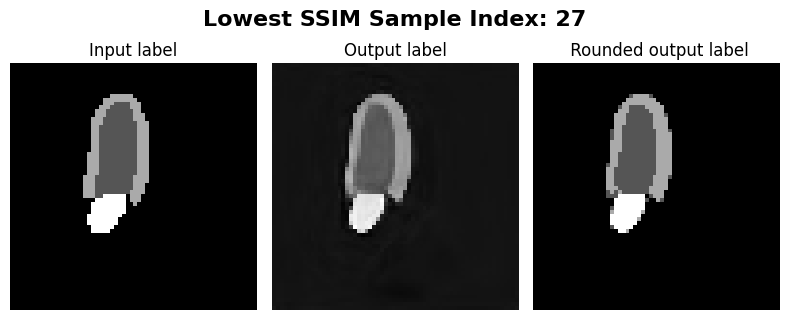

In [ ]:
import torch
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.nn import MSELoss

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#model = torch.load('/content/drive/MyDrive/project_ae/logs/ae/best_metric_model.pth', map_location=torch.device('cpu'))
model = torch.load('/content/drive/MyDrive/project_ae/logs/ae/best_metric_model.pth')

test_loss_function = MSELoss()
test_loss_list = []

test_accuracy_list = []
test_ssim_list = []

test_step = 0
max_acc = 0.0
min_acc = 100.0
max_ssim = 0.0
min_ssim = 1.0
max_acc_sample = None
min_acc_sample = None
max_ssim_sample = None
min_ssim_sample = None

with torch.no_grad():
    for test_batch_data in test_dataloader:
        test_step += 1
        model.eval()
        model.to(device)
        test_inputs = test_batch_data["label"].to(device)
        test_outputs = model(test_inputs)
        test_loss = test_loss_function(test_outputs, test_inputs)
        test_loss_list.append(test_loss.item())

        # accuracy calculation for test dataset
        round_test_outputs = torch.round(test_outputs)
        test_correct_pixel = torch.sum(torch.eq(test_inputs, round_test_outputs)).item()
        test_total_pixel = test_inputs.numel()
        test_acc = (test_correct_pixel / test_total_pixel) * 100
        test_accuracy_list.append(test_acc)

        # ssim calculation for test dataset
        test_out_np = test_outputs.cpu().detach().numpy()
        test_in_np = test_inputs.cpu().detach().numpy()
        test_ssim = ssim(test_out_np[0, 0], test_in_np[0, 0])
        test_ssim_list.append(test_ssim)

        # Save the sample with the highest accuracy
        if test_acc > max_acc:
            max_acc = test_acc
            max_acc_sample = {
                'idx': test_step,
                'input': test_inputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'output': test_outputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'rounded_output': round_test_outputs.squeeze().transpose(1, 0)
            }

        # Save the sample with the lowest accuracy
        if test_acc < min_acc:
            min_acc = test_acc
            min_acc_sample = {
                'idx': test_step,
                'input': test_inputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'output': test_outputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'rounded_output': round_test_outputs.squeeze().transpose(1, 0)
            }

        # Save the sample with the highest SSIM
        if test_ssim > max_ssim:
            max_ssim = test_ssim
            max_ssim_sample = {
                'idx': test_step,
                'input': test_inputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'output': test_outputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'rounded_output': round_test_outputs.squeeze().transpose(1, 0)
            }

        # Save the sample with the lowest SSIM
        if test_ssim < min_ssim:
            min_ssim = test_ssim
            min_ssim_sample = {
                'idx': test_step,
                'input': test_inputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'output': test_outputs.squeeze().detach().cpu().numpy().transpose(1, 0),
                'rounded_output': round_test_outputs.squeeze().transpose(1, 0)
            }

test_sample_idx = list(range(1, test_step + 1, 1))

plt.figure("Test", (16, 8))
plt.suptitle("Test History", x=0.5, y=1.0, fontsize=20, fontweight='bold')
ax = plt.subplot(1, 3, 1)
plt.title("Test loss")
plt.xlabel("Sample index")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(test_sample_idx, test_loss_list, color="black", label="Sample loss")
plt.legend(loc="upper right")

ax = plt.subplot(1, 3, 2)
plt.title("Test Accuracy")
plt.xlabel("Sample index")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(test_sample_idx, test_accuracy_list, color="black", label="Sample accuracy")
plt.legend(loc="upper right")

ax = plt.subplot(1, 3, 3)
plt.title("Test SSIM")
plt.xlabel("Sample index")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(test_sample_idx, test_ssim_list, color="black", label="Sample SSIM")
plt.legend(loc="upper right")

# Plot the input label, output label, rounded output label
figure = plt.figure(figsize=(8, 8))
figure.suptitle(f"Highest Accuracy Sample Index: {max_acc_sample['idx']}", x=0.5, y=0.7, fontsize=16, fontweight='bold')
ax = figure.add_subplot(1, 3, 1)
imagesc(ax, max_acc_sample['input'], title="Input label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 2)
imagesc(ax, max_acc_sample['output'], title="Output label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 3)
imagesc(ax, max_acc_sample['rounded_output'], title=" Rounded output label", show_colorbar=False)
figure.tight_layout()
plt.show()

figure = plt.figure(figsize=(8, 8))
figure.suptitle(f"Lowest Accuracy Sample Index: {min_acc_sample['idx']}", x=0.5, y=0.7, fontsize=16, fontweight='bold')
ax = figure.add_subplot(1, 3, 1)
imagesc(ax, min_acc_sample['input'], title="Input label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 2)
imagesc(ax, min_acc_sample['output'], title="Output label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 3)
imagesc(ax, min_acc_sample['rounded_output'], title=" Rounded output label", show_colorbar=False)
figure.tight_layout()
plt.show()

figure = plt.figure(figsize=(8, 8))
figure.suptitle(f"Highest SSIM Sample Index: {max_ssim_sample['idx']}", x=0.5, y=0.7, fontsize=16, fontweight='bold')
ax = figure.add_subplot(1, 3, 1)
imagesc(ax, max_ssim_sample['input'], title="Input label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 2)
imagesc(ax, max_ssim_sample['output'], title="Output label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 3)
imagesc(ax, max_ssim_sample['rounded_output'], title=" Rounded output label", show_colorbar=False)
figure.tight_layout()
plt.show()

figure = plt.figure(figsize=(8, 8))
figure.suptitle(f"Lowest SSIM Sample Index: {min_ssim_sample['idx']}", x=0.5, y=0.7, fontsize=16, fontweight='bold')
ax = figure.add_subplot(1, 3, 1)
imagesc(ax, min_ssim_sample['input'], title="Input label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 2)
imagesc(ax, min_ssim_sample['output'], title="Output label", show_colorbar=False)
ax = figure.add_subplot(1, 3, 3)
imagesc(ax, min_ssim_sample['rounded_output'], title=" Rounded output label", show_colorbar=False)
figure.tight_layout()
plt.show()